# 3. Analysis
## 3.1. Q1: General patterns - Most frequent words

In [30]:
import pandas as pd
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt
import translators as ts
import translators.server as tss
from wordcloud import WordCloud

In [31]:
%run "3.0. Analysis_Functions.ipynb"

In [32]:
%run "0.1. Intro_Visualization style.ipynb"

## Useful functions

In [33]:
def wordcloud_grid(df, translation, suptitle):
    
    """
    Builds workcloud
    
    Args:
    df - dataframe with dictionaries
    translation - dataframe with translated words from RU to EN
    suptitle - string
    """
    
    wc = WordCloud(background_color="white",
                   random_state=42, 
                   width=1000,height=1000, 
                   max_words=n_wc,
                   normalize_plurals=False)
    
    fig, ax = plt.subplots(round(len(df.index)/3), 3, figsize=(14,30))
    
    for indx in range(len(df.index)):
        dic_index = df.iloc[indx,1]
        
        # Transform dictionary into dataframe (for one year)
        # Index here is a word in Russian
        df_index = pd.DataFrame.from_dict(dic_index, 
                                          orient='index',
                                          columns=['frequency'])
        # Merge with translation
        df_index_en = df_index.merge(translation['eng'], how='left', 
                                     left_index=True, right_index=True)
        df_index_en = df_index_en[['eng', 'frequency']]
        
        # Transform dataframe into dic for wordcloud
        df_index_en = df_index_en.set_index('eng')
        dic_index_en = df_index_en.to_dict()
        dic_index_en = dic_index_en['frequency']
        
        # WordCloud
        wc_gen = wc.generate_from_frequencies(dic_index_en)
        plt.subplot(6, 3, indx+1)
        plt.imshow(wc_gen)
        plt.axis("off")
        
        title = df.index[indx]
        if df.index[indx]==2006:
            title = "2006/09-2006/12"
        if df.index[indx]==2023:
            title = "2023/01"    
        #plt.title(title, c='#00008B', weight='bold')
        plt.title(title, weight='bold', size=16)
    
    plt.suptitle(suptitle, fontsize=18, c=color_txt_labels, weight='bold')
    plt.subplots_adjust(left=0.1,
                        bottom=0.23,
                        right=0.9,
                        top=0.96,
                        wspace=0.1)

## Data loading

In [34]:
# Path to tokenized data
file = 'data/df_tokenized.csv'

In [35]:
df = pd.read_csv(file)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [38]:
pd.reset_option('display.max_colwidth')
df.head(3)

id_in_source_file                 date  tags_top  \
0                 15  2023-01-27 21:45:00  Общество   
1                 16  2023-01-27 21:35:00  Культура   
2                 20  2023-01-27 21:34:00     Спорт   

                                               title  \
0     Выпуск программы «Время» в 21:00 от 27.01.2023   
1  В Москве проходит церемония вручения премии «З...   
2             В Туле появился новый футбольный манеж   

                                                 url  \
0  https://www.1tv.ru/news/2023-01-27/446104-vypu...   
1  https://www.1tv.ru/news/2023-01-27/446121-v_mo...   
2  https://www.1tv.ru/news/2023-01-27/446120-v_tu...   

                                                body  \
0  Смотрите в этом выпуске: 79 лет назад была пол...   
1  Событие в мире отечественного кино. В Москве в...   
2  Футбольный манеж в Туле — искусственный газон ...   

                                         tags_bottom  video_duration_seconds  \
0                                           Общество                  2422.0   
1  Культура,Кино,Марина Зудина,Екатерина Климова,...                   290.0   
2  Спорт,Регионы,Футбол,Алексей Дюмин,Тульская об...                    48.0   

  file_key             datetime         dat  year year_month  hour  weekday  \
0     0-15  2023-01-27 21:45:00  2023-01-27  2023    2023-01    21        4   
1     0-15  2023-01-27 21:35:00  2023-01-27  2023    2023-01    21        4   
2     0-15  2023-01-27 21:34:00  2023-01-27  2023    2023-01    21        4   

   whole newscast                                   body_token_final  \
0            True  ['смотреть', 'выпуск', '79', 'год', 'полностью...   
1           False  ['событие', 'мир', 'отечественный', 'кино', 'м...   
2           False  ['футбольный', 'манеж', 'тула', 'искусственный...   

                                   title_token_final  
0  ['выпуск', 'программа', 'время', '21:00', '27....  
1  ['москва', 'проходить', 'церемония', 'вручение...  
2  ['тула', 'появиться', 'новый', 'футбольный', '...

In [39]:
df.shape

(359041, 18)

## Most frequent words

### Params

In [40]:
# Additional stop list which is relevant for news
stop_list = ['раз', 'один', 'два', 'три', 'пять', 'тысяча', 'миллион', 'десяток', 'число',
             'день', 'год', 'сегодня', 'сутки', 'время', 'неделя', 'ночь', 'час', 
             'новость', 'выпуск', 'программа', 'кадр', 'история', 'видеообзор', 
             'вести', 'весть',
             'шоу', 'последний', 'телеканал',
             '07:00', '09:00', '12:00', '13:00', '14:00', '15:00', '18:00', '21:00',
             '2008', '2009', '2010', '2018', 
             'новый', 'первый', 'канал', 'второй', 'v', '™',
             'случай', 'событие', 'ход', 'имя']

# List of words that should be merged into one because their meanings are similar.
merge =  [['россия', 'российский', 'рф'], 
          ['москва', 'московский'], 
          ['украина', 'украинский', 'украинских', 'украинские',
           'украинского', 'украинской', 'украинскими', 'украинская'], 
          ['киев', 'киевский'], 
          ['область', 'регион', 'край'], 
          ['сша', 'америка', 'американский'],
          ['лнр', 'луганск', 'луганский'],
          ['великобритания', 'британский'],
          ['европа', 'европейский'],
          ['ес', 'евросоюз'],
          ['запад', 'западный'],
          ['сирия', 'сирийский'],
          ['коронавирус', 'covid-19'],
          ['проходить', 'пройти'],
          ['заседание', 'совещание', 'встретиться'],
          ['боевой', 'боец'],
          ['байден', 'байдена', 'байдену'],
          ['встреча', 'встретиться'],
          ['государство', 'государственный'],
          ['грузия', 'грузинский'],
          ['медведев', 'д.медведев'],
          ['днр', 'донецк', 'донецкий'],
          ['начать', 'начаться'],
          ['ребёнок', 'ребeнок', 'детский'],
          ['обсудить', 'обсуждать', 'обсуждаться'],
          ['олимпиада', 'олимпийский'],
          ['освобождение', 'освободить', 'освобождать'],
          ['открыть', 'открыться'], 
          ['полиция', 'полицейский'],
          ['продолжать', 'продолжаться'],
          ['работа', 'рабочий'],
          ['решить', 'решение'],
          ['россиянин', 'русский', 'русских'],
          ['спецоперация', 'сво'],
          ['столица', 'столичный'],
          ['теракт', 'террорист'],
          ['участие', 'участник'],
          ['футбол', 'футбольный'],
          ['центр', 'центральный'],
          ['южный', 'юго'],
          ['леопард', 'leopard'],
          ['переговоры', 'переговоров'],
          ['нато', 'натовский'],
          ['вооружение', 'вооружить'],
          ['газ', 'газовый', 'газопровод'],
          ['готовить', 'готовиться'],
          ['договорённость', 'договор'],
          ['зеленский','зеленского'],
          ['конституционный', 'конституция'],
          ['курманбек', 'курманбека'],
          ['медведчук', 'медведчука', 'медведчуку'],
          ['минск', 'минский'],
          ['намерение', 'намерен'],
          ['начаться', 'начинаться'],
          ['нацист', 'неонацистский'],
          ['обстрел', 'обстрелять'],
          ['ополченец', 'ополчение'],
          ['оппозиция', 'оппозиционный', 'оппозиционер'],
          ['ответить', 'отвечать'],
          ['отправить', 'отправка'],
          ['официальный', 'официально'],
          ['парламент', 'парламентский'],
          ['подписать', 'подписание'],
          ['правительство', 'правительственный'],
          ['прекратить', 'прекращение'],
          ['провести', 'проводить'], 
          ['продолжать', 'продолжаться'],
          ['расследование', 'расследовать'],
          ['рассмотреть', 'рассматривать'],
          ['скандал', 'скандальный'],
          ['сообщить', 'сообщать'],
          ['чернобыльский', 'чернобылец'],
          ['язык', 'языковой'],
          ['защита', 'защищать'],
          ['националист', 'националистический'],
          ['нацист', 'неонацист'],
          ['николаев', 'николаевский'],
          ['оборона', 'оборонный', 'обороной'],
          ['помощь', 'помогать', 'помочь']]

# Translation dictionary from RU to EN for words where automatic translation fails
dict_ru_en = {'глава': 'head',
              'обсудить': 'discuss',
              'работа': 'work',
              'начаться': 'start',
              'боевик': 'militant',
              'военнослужащий': 'soldier',
              'всу': 'Ukraine Armed forces',
              'дтп': 'car accident',
              'мид': 'Ministry of Foreign Affairs',
              'сво': 'special operation',
              'силовик': 'enforcer',
              'борьба': 'fight',
              'единый': 'united',
              'обсудить': 'discuss',
              'рада': 'Ukrainian Rada',
              'режим': 'regime',
              'бюллетень': 'ballot',
              'жеребьёвка': 'sortition',
              'константинопольский': 'Constantinopolitan',
              'крушение': 'crash',
              'нанести': 'strike',
              'населить': 'populate',
              'сбу': 'Ukrainian security service',
              'совбез': 'Security Council',
              'спутник': 'Sputnik V',
              'рассчитаться': 'pay off',
              'потасовка': 'scrimmage',
              'освободить': 'liberate'} 

# Number of the most frequent words for counting
n = 130

# Number of the most frequent words to show in wordcloud
n_wc = 100

### Most frequent words in news title

In [41]:
# Find the most frequent words in the column 'title_token_final'
frequent_words = \
    find_most_frequent(df, 'title_token_final', n, token_dict=None, groupby=None)

In [42]:
# Delete words from the stop-list
frequent_words = delete_stop_words(frequent_words, stop_list)

In [43]:
# Merge words with similar meaning into one word
frequent_words_merged = merge_words(frequent_words, merge)

In [44]:
# Translate words from RU to EN
translation = translate_ru_en(frequent_words_merged, dict_ru_en)

pd.set_option('display.max_rows', None)
translation

eng  frequency
россия                      Russia      67340
москва                      Moscow      22985
владимир                  Vladimir      16270
президент                president      15221
путин                        Putin      15146
область                     region      23804
человек                      Human      11054
сша                            USA      15356
украина                    Ukraine      10790
страна                     country       8678
мир                          world       8592
дело                          case       7855
глава                         head       7421
военный                   military       7327
провести                   conduct       6687
житель                  inhabitant       6620
дмитрий                    Dmitriy       6105
город                         city       6049
ребёнок                      child       5965
обсудить                   discuss       5808
медведев                  Medvedev       5635
центр                       center       5584
чемпионат             championship       5572
погибнуть                      die       5491
пожар                         fire       5317
международный        international       5024
крупный                      large       4959
работа                        work       4759
правительство           government       4722
проходить                     pass      12810
ситуация                 situation       4649
петербург               Petersburg       4647
сирия                        Syria       4639
суд                          court       4600
сборная              national team       4439
выбор                       choice       4432
задержать                   detain       4371
европа                      Europe       4323
принять                     accept       4304
дом                          house       4293
премьер             Prime Minister       4266
министр                   Minister       4172
отмечать                      note       4168
коронавирус            Coronavirus       3882
встреча                    meeting       3849
сергей                      Sergey       3802
вопрос                    question       3747
госдума                 State Duma       3746
результат                   result       3657
заседание                  meeting       9193
жизнь                         life       3608
помощь                        help       3513
власть                       power       3496
состояться              take place       3492
восток                        East       3491
совет                       advice       3466
против                     against       3447
франция                     France       3427
победа                     victory       3425
получить                       get       3417
донбасс                    Donbass       3378
матч                         match       3371
акция                    promotion       3339
самолёт                   airplane       3290
столица                    capital       3270
главный                       main       3265
киев                          Kyiv       3257
стартовать                   start       3254
объявить                   declare       3223
операция                 operation       3151
германия                   Germany       3108
футбол                    football       3099
россиянин                  Russian       3090
район                         area       3043
участие              participation       6002
развитие               development       2972
итог                        result       2962
безопасность                safety       2909
взрыв                    explosion       2907
произойти                   happen       2903
санкт                        Saint       2851
начать                       begin       6048
лидер                       leader       2821
сила                         force       2796
боевик                    militant       2736
сотрудник                 employee       2725
открыть                      

In [45]:
# Convert dataframe into a dictionary for wordcloud
frequent_words_eng = translation.set_index('eng')
frequent_words_eng = frequent_words_eng.to_dict()
frequent_words_eng = frequent_words_eng['frequency']

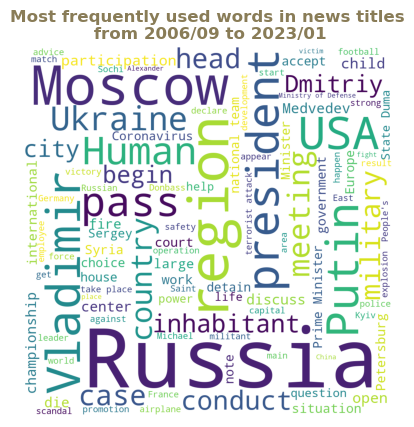

In [46]:
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=n_wc,normalize_plurals=False).generate_from_frequencies(frequent_words_eng)
plt.title('Most frequently used words in news titles\n from 2006/09 to 2023/01', 
          weight='bold')
plt.axis("off")
plt.imshow(wc);

### Most frequent words in news title by year

In [47]:
#token_dict = {'title_token_final': ['украин', 'киев']}
frequent_words_by_year = \
    find_most_frequent(df, 'title_token_final', n, token_dict=None, groupby='year')

In [48]:
frequent_words_by_year = delete_stop_words(frequent_words_by_year, words_to_delete=stop_list)

In [49]:
pd.set_option('display.max_colwidth', None)
frequent_words_by_year

title_token_final  \
year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2006                                                                                                          [(россия, 424), (российский, 260), (новый, 252), (москва, 245), (год, 243), (президент, 239), (страна, 149), (область, 141), (владимир, 130), (первый, 125), (пройти, 125), (дело, 123), (путин, 113), (человек, 109), (мир, 104), (день, 102), (проходить, 101), (министр, 98), (правительство, 97), (грузия, 94), (глава, 93), (провести, 92), (сша, 82), (заседание, 81), (петербург, 80), (военный, 73), (суд, 73), (госдума, 72), (совет, 69), (ребёнок, 68), (выбор, 68), (город, 65), (отмечать, 64), (житель, 62), (крупный, 62), (погибнуть, 60), (два, 58), (рф, 58), (центр, 57), (международный, 57), (дом, 56), (вопрос, 56), (открыться, 54), (убийство, 54), (проект, 54), (совещание, 53), (ситуация, 53), (южный, 53), (проблема, 52), (приговор, 51), (безопасность, 51), (премьер, 49), (встреча, 49), (столица, 48), (взрыв, 48), (украина, 48), (начаться, 48), (партия, 47), (кремль, 47), (готовиться, 46), (работа, 46), (пожар, 45), (михаил, 44), (американский, 44), (санкт, 44), (результат, 44), (юбилей, 44), (оон, 44), (осетия, 44), (время, 43), (лидер, 43), (принять, 43), (ядерный, 43), (ливан, 43), (второй, 43), (тысяча, 42), (получить, 42), (республика, 42), (жизнь, 42), (авария, 42), (дмитрий, 42), (главный, 41), (состояться, 41), (встретиться, 41), (власть, 41), (сергей, 41), (причина, 41), (переговоры, 40), (задержать, 40), (государственный, 40), (открыть, 39), (произойти, 39), (прибыть, 39), (ночь, 39), (объявить, 39), (член, 38), (обсуждать, 37), (парламент, 37), (итог, 37), (северный, 37), ...]   
2007          [(россия, 1475), (новый, 870), (москва, 814), (российский, 801), (год, 798), (президент, 672), (область, 630), (день, 553), (первый, 527), (человек, 502), (путин, 474), (владимир, 468), (страна, 435), (пройти, 408), (дело, 367), (сша, 358), (город, 353), (мир, 336), (выбор, 333), (суд, 300), (американский, 291), (правительство, 289), (украина, 277), (житель, 268), (крупный, 254), (проходить, 252), (министр, 248), (погибнуть, 247), (международный, 246), (премьер, 246), (пожар, 242), (ребёнок, 241), (отмечать, 240), (провести, 238), (два, 232), (центр, 224), (заседание, 222), (глава, 221), (дом, 219), (тысяча, 212), (столица, 209), (работа, 207), (взрыв, 205), (начаться, 205), (сергей, 203), (открыться, 200), (пет

In [50]:
frequent_words_by_year_merged = merge_words(frequent_words_by_year, lists_for_merge=merge)

In [51]:
# Translate all the words in dataframe from RU to EN
translation = translate_df_of_dict(frequent_words_by_year_merged, dict_ru_en)

In [52]:
translation

eng  frequency
россия                                Russia      67340
москва                                Moscow      22716
президент                          president      15221
страна                               country       8678
область                               region      23007
владимир                            Vladimir      16270
дело                                    case       7844
путин                                  Putin      15146
человек                                Human      11054
мир                                    world       8592
проходить                               pass      12786
министр                             Minister       4172
правительство                     government       4722
грузия                               Georgia        964
глава                                   head       7421
провести                             conduct       6687
сша                                      USA      15349
заседание                            meeting       6340
петербург                         Petersburg       4440
военный                             military       7327
суд                                    court       4228
госдума                           State Duma       3382
совет                                 advice       3283
ребёнок                                child       5965
выбор                                 choice       4315
город                                   city       6049
отмечать                                note       4168
житель                            inhabitant       6620
крупный                                large       4741
погибнуть                                die       5491
центр                                 center       6706
международный                  international       5011
дом                                    house       4123
вопрос                              question       3576
убийство                              murder       1731
проект                               project        827
ситуация                           situation       4649
южный                                  South        858
проблема                             problem        672
приговор                            sentence       1066
безопасность                          safety       2150
премьер                       Prime Minister       4266
встреча                              meeting       3847
столица                              capital       2765
взрыв                              explosion       2122
украина                              Ukraine      12709
начаться                               start        223
партия                           consignment       1174
кремль                               Kremlin        228
готовиться                           prepare        477
работа                                  work       5083
пожар                                   fire       5159
михаил                               Michael       1305
санкт                                  Saint       1878
результат                             result       3407
юбилей                           anniversary        731
оон                                       UN        933
осетия                               Ossetia        536
лидер                                 leader       1657
принять                               accept       4294
ядерный                              nuclear         43
ливан                                Lebanon         43
получить                                 get       2975
республика                          republic        730
жизнь                                   life       3233
авария                              accident       1408
дмитрий                              Dmitriy       5876
главный                                 main       3070
состояться                        take place       3480
власть                                 power       2930
сергей                                Sergey       3188
причина  

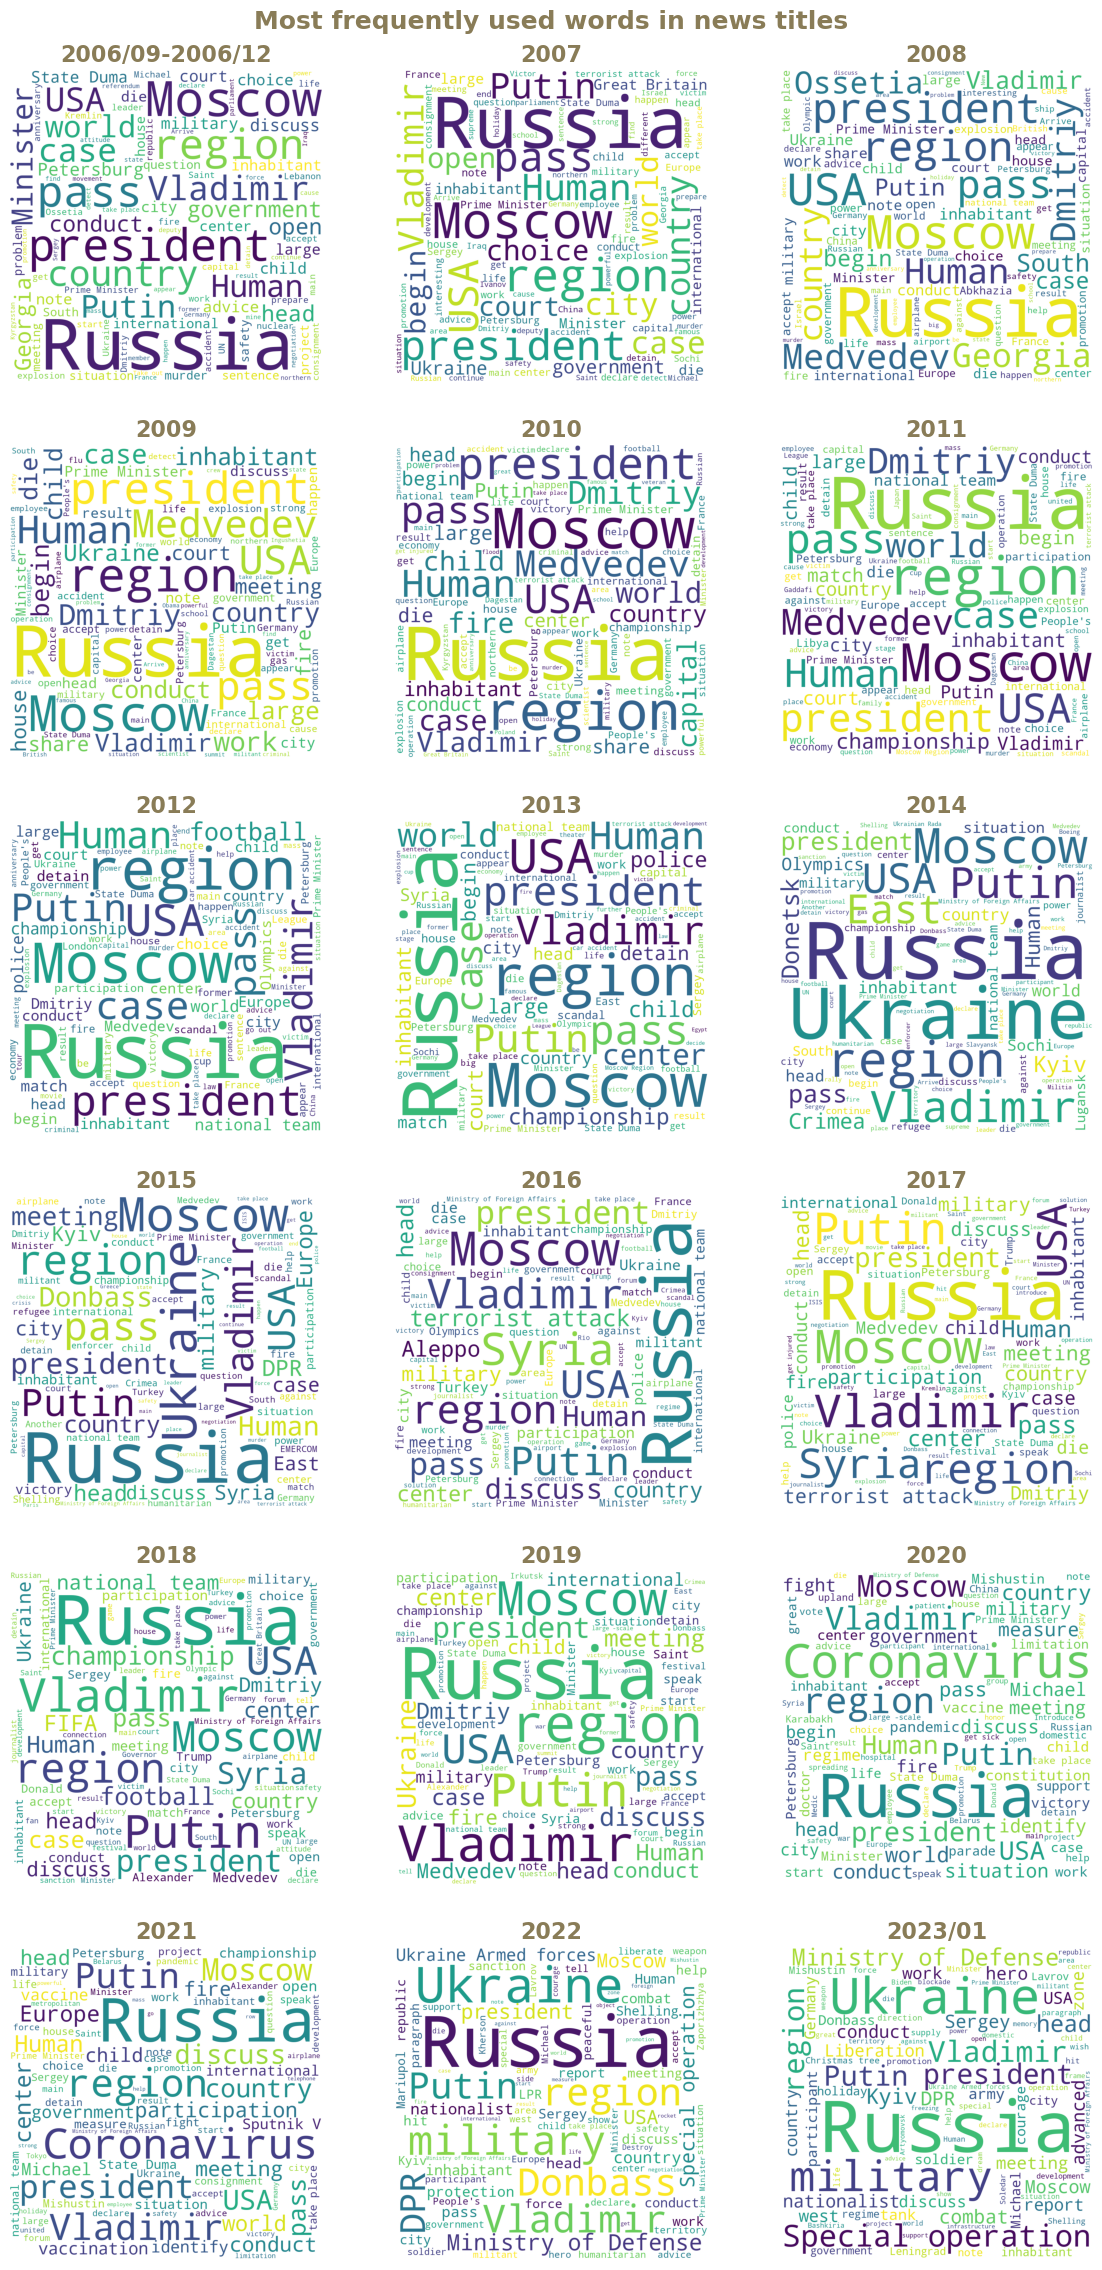

In [53]:
wordcloud_grid(frequent_words_by_year_merged, translation, 
               suptitle='Most frequently used words in news titles')

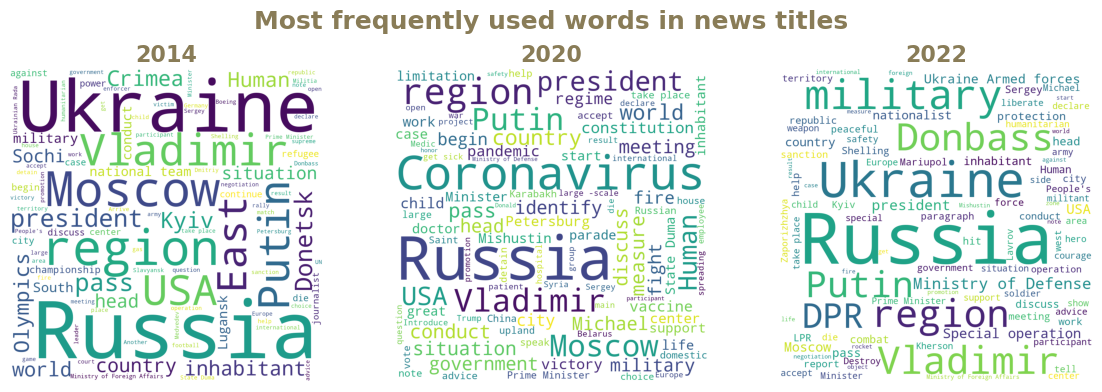

In [54]:
# Shorter version for the report
years_list = [2014, 2020, 2022]
wordcloud_grid(frequent_words_by_year_merged[frequent_words_by_year_merged.index.isin(years_list)], 
               translation, 
               suptitle='Most frequently used words in news titles')

## Most frequent words (target: Ukraine)

### Params

In [55]:
# Number of the most frequent words for counting
n = 70

# Number of the most frequent words to show in wordcloud
n_wc = 50

token_dict = {'title_token_final': ['украин', 'киев']}

stop_list_ua =  ['россия', 'российский', 'рф', 'русских', 'российско',
                 'русский', 'русско', 'русь',
                 'москва', 'московский',
                 'украина', 'украинский', 'украинская', 'украинских', 
                 'украинские', 'украинского', 'украинской', 'украинскими', 
                 'украинец', 'украинском',
                 'киев', 'киевский',
                 'оказаться', '7', '50', '60', 'пункт']
stop_list_ua.extend(stop_list)

In [56]:
frequent_words_by_year = \
    find_most_frequent(df, 'title_token_final', n, token_dict=token_dict, groupby='year')

In [57]:
frequent_words_by_year = delete_stop_words(frequent_words_by_year, words_to_delete=stop_list_ua)

In [58]:
frequent_words_by_year_merged = merge_words(frequent_words_by_year, lists_for_merge=merge)

In [59]:
pd.set_option('display.max_colwidth', None)
frequent_words_by_year_merged

title_token_final  \
year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2006                                                                                                   [(украина, 48), (киев, 17), (новый, 11), (президент, 9), (нато, 9), (министр, 7), (российский, 7), (россия, 6), (пройти, 6), (крым, 5), (страна, 5), (киргизия, 5), (бакиев, 5), (правительство, 5), (путин, 4), (виктор, 4), (встретиться, 4), (первый, 4), (переговоры, 4), (референдум, 4), (вступление, 4), (глава, 4), (рада, 4), (конституция, 4), (газ, 4), (янукович, 4), (украинского, 3), (владимир, 3), (кризис, 3), (политический, 3), (скандал, 3), (мид, 3), (тарасюк, 3), (депутат, 3), (два, 3), (курманбек, 3), (подписать, 3), (проводить, 3), (парламент, 3), (верховный, 3), (михаил, 3), (фрадков, 3), (партия, 3), (трагедия, 3), (поставка, 3), (год, 2), (ющенко, 2), (украинской, 2), (иностранный, 2), (дело, 2), (проходить, 2), (отношение, 2), (найти, 2), (оказаться, 2), (сергей, 2), (продолжаться, 2), (борис, 2), (районный, 2), (суд, 2), (отставка, 2), (премьер, 2), (обсудить, 2), (проект, 2), (война, 2), (украинский, 2), (украинском, 2), (фестиваль, 2), (сала, 2), (запретить, 2), (съезд, 2)]   
2007                                                         [(украина, 277), (рада, 67), (верховный, 57), (выбор, 47), (президент, 44), (киев, 43), (политический, 34), (ющенко, 30), (суд, 30), (виктор, 28), (парламент, 27), (конституционный, 27), (кризис, 25), (день, 22), (новый, 22), (досрочный, 22), (парламентский, 20), (премьер, 19), (заседание, 18), (россия, 17), (тимошенко, 16), (министр, 13), (юлия, 13), (украинский, 13), (правительство, 12), (газ, 12), (партия, 11), (указ, 11), (роспуск, 11), (депутат, 10), (встреча, 10), (ситуация, 9), (российский, 9), (готовиться, 8), (человек, 8), (погибнуть, 8), (взрыв, 8), (последний, 8), (украинской, 8), (улица, 8), (нато, 8), (янукович, 8), (регион, 7), (лидер, 7), (скандал, 7), (авария, 7), (газопровод, 7), (украинские, 7), (москва, 7), (пройти, 7), (дело, 7), (отставка, 7), (украинского, 6), (киевский, 6), (украинском, 6), (проходить, 6), (ликвидировать, 6), (глава, 6), (неделя, 6), (шахта, 6), (первый, 6), (страна, 6), (объявить, 6), (украинских, 6), (начаться, 6), (голос, 6), (продолжаться, 6), (состояться, 6), (акция, 6), (протест, 6)]   
2008                                                      [(украина, 372), (киев, 112), (рада, 56), (президент, 48), (верховный, 45), (поставка, 42), (газ, 38), (нато, 38), (новый, 37), (украинского, 36), (россия, 35), (грузия, 32), (судно, 31), (газпром, 27), (фаина, 27), (ющенко, 24), (российский, 23), (оружие, 22), (долг, 21), (тимошенко, 20), (день, 19), (премьер, 19), (коалиция, 19), (виктор, 19), (газовый, 18), (парламентский, 18), (пройти, 18), (пират, 18), (сухогруз, 18), (украинские, 18), (украинской, 17), (скандал, 17), (парламент, 17), (мэр, 16), (выбор, 16), (год, 15), (вопрос, 15), (киевский, 15), (русь, 15), (юлия, 14), (кризис, 1

In [60]:
# Translate all the words in dataframe from RU to EN
translation = translate_df_of_dict(frequent_words_by_year_merged, dict_ru_en)

In [61]:
translation

eng  frequency
президент                               president       1124
нато                                         NATO         78
министр                                  Minister        115
крым                                       Crimea        145
страна                                    country        501
киргизия                               Kyrgyzstan         33
бакиев                                     Bakiev         53
правительство                          government         88
путин                                       Putin        442
виктор                                     Victor        183
встретиться                                  Meet          4
переговоры                            negotiation         61
референдум                             referendum          4
вступление                           introduction         18
глава                                        head        490
рада                               Ukrainian Rada        633
конституция                          constitution          4
газ                                           gas        446
янукович                               Yanukovych         73
владимир                                 Vladimir        630
кризис                                     crisis        340
политический                            political         68
скандал                                   scandal         94
мид                   Ministry of Foreign Affairs        311
тарасюк                                   Tarasuk          3
депутат                                    deputy         75
курманбек                               Kurmanbek         34
подписать                                    sign         12
проводить                                 conduct          3
парламент                              parliament        116
верховный                                 supreme        566
михаил                                    Michael         50
фрадков                                   Fradkov          3
партия                                consignment         22
трагедия                                  tragedy          3
поставка                                   supply        229
ющенко                                 Yushchenko         68
иностранный                               foreign          2
дело                                         case        295
проходить                                    pass        123
отношение                                attitude         31
найти                                        find          2
сергей                                     Sergey         86
продолжаться                             continue         19
борис                                       Boris          2
районный                                 district          2
суд                                         court        275
отставка                              resignation         75
премьер                            Prime Minister        129
обсудить                                  discuss        499
проект                                    project          2
война                                         war          2
фестиваль                                festival          2
сала                                         Sala          2
запретить                                prohibit          2
съезд                                    Congress          2
выбор                                      choice        362
конституционный                    constitutional         27
досрочный                                   early         32
заседание                                 meeting        148
тимошенко                              Tymoshenko        144
юлия                                        Julia        143
указ                                       decree         11
роспуск                               dissolution         24
встреча                                   meeting         77
ситуация            

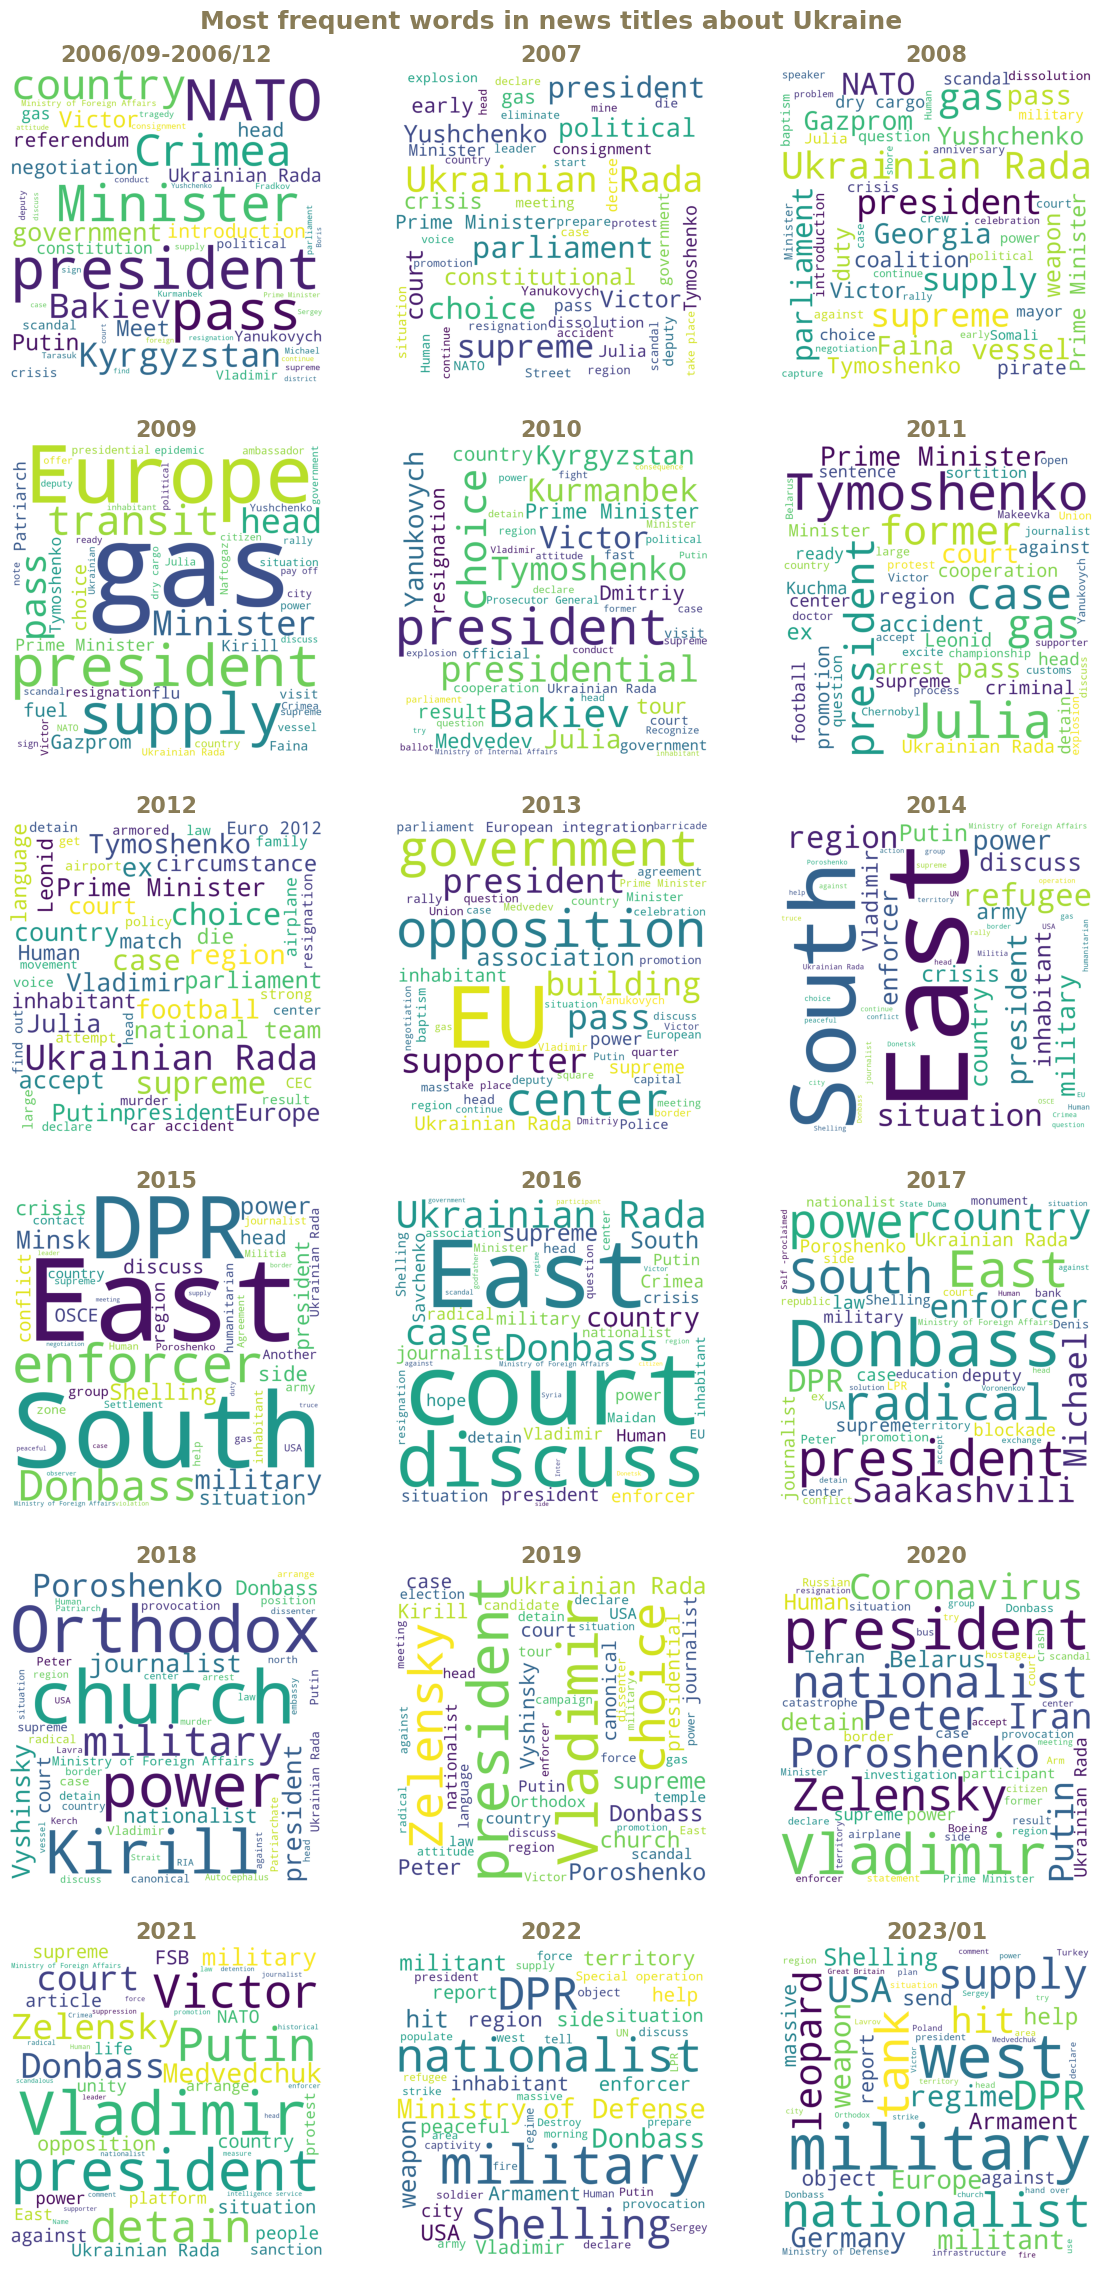

In [62]:
wordcloud_grid(frequent_words_by_year_merged, translation, 
               suptitle='Most frequent words in news titles about Ukraine')

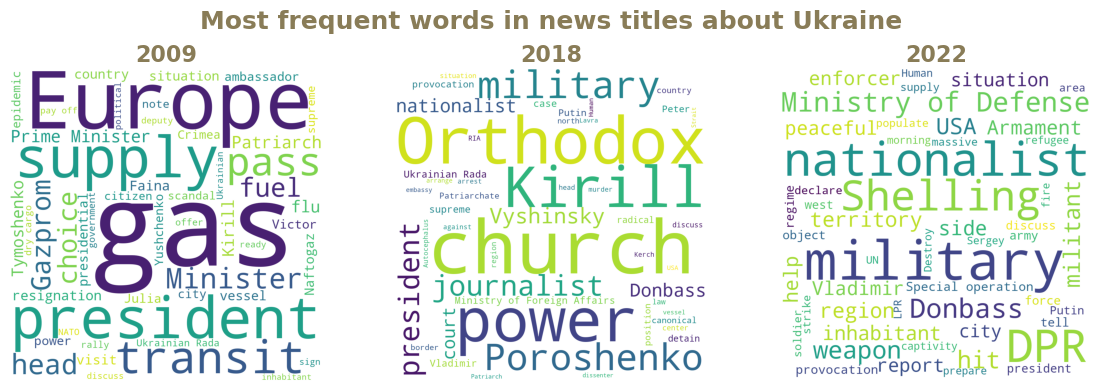

In [63]:
# Shorter version for the report
years_list = [2009, 2018, 2022]
wordcloud_grid(frequent_words_by_year_merged[frequent_words_by_year_merged.index.isin(years_list)], 
               translation, 
               suptitle='Most frequent words in news titles about Ukraine')

## Most frequent words (target: Special military operation)

### Params

In [64]:
# Number of the most frequent words for counting
n = 130

# Number of the most frequent words to show in wordcloud
n_wc = 100

token_dict = {'tags_bottom': ['Специальная военная операция']}

In [65]:
# Find the most frequent words in the column 'title_token_final'
frequent_words = \
    find_most_frequent(df, 'body_token_final', n, token_dict=token_dict, groupby=None)

In [66]:
# Delete words from the stop-list
frequent_words = delete_stop_words(frequent_words, stop_list_ua)

In [67]:
# Merge words with similar meaning into one word
frequent_words_merged = merge_words(frequent_words, merge)

In [68]:
# Translate words from RU to EN
translation = translate_ru_en(frequent_words_merged, dict_ru_en)

pd.set_option('display.max_rows', None)
translation

eng  frequency
военный                     military       7200
район                           area       4165
человек                        Human       4113
уничтожить                   Destroy       3769
удар                             hit       3721
националист              nationalist       3689
всу             Ukraine Armed forces       3612
сила                           force       3412
огонь                           fire       3125
город                           city       3014
житель                    inhabitant       2922
область                       region       2842
боевой                        combat       4149
республика                  republic       2737
мирный                      peaceful       2580
минобороны       Ministry of Defense       2569
народный                    People's       2460
населить                    populate       2453
техника                    technique       2407
оружие                        weapon       2399
боевик                      militant       2283
донбасс                      Donbass       2252
войско                          army       2205
страна                       country       2186
подразделение            subdivision       2153
противник                      enemy       2138
ракета                        rocket       2099
позиция                     position       2094
территория                 territory       2094
сообщить                      report       2056
обстрел                     Shelling       1962
репортаж                   reportage       1953
система                       system       1884
военнослужащий               soldier       1786
помощь                          help       1771
снаряд                         shell       1764
днр                              DPR       4667
представитель         representative       1682
сторона                         side       1638
объект                        object       1635
оборона                      defense       1612
цель                          target       1599
ракетный                     missile       1586
операция                   operation       1580
результат                     result       1552
боеприпас                 ammunition       1544
получить                         get       1533
действие                      action       1532
машина                           car       1521
дом                            house       1501
говорить                       speak       1494
режим                         regime       1397
группа                         group       1392
направление                direction       1390
рассказать                      tell       1344
погибнуть                        die       1342
игорь                           Igor       1340
артиллерия                 artillery       1336
вооружение                  Armament       2526
работа                          work       1310
специальный                  special       1277
бой                           battle       1253
задача                          task       1251
ребёнок                        child       1240
комплекс                     complex       1221
работать                        work       1221
президент                  president       1175
спецоперация       Special operation       1157
гуманитарный            humanitarian       1153
центр                         center       1151
официальный                 official       1139
управление                   control       1132
владимир                    Vladimir       1132
нанести                       strike       1131
артиллерийский             artillery       1131
западный                        west       1129
заявить                      declare       1129
жизнь                           life       1124
атака                         attack       1118
огневой                         fire       1108
залповый                      volley       1108
важный                     important       1106
лнр                              LPR       2152
м

In [69]:
# Convert dataframe into a dictionary for wordcloud
frequent_words_eng = translation.set_index('eng')
frequent_words_eng = frequent_words_eng.to_dict()
frequent_words_eng = frequent_words_eng['frequency']

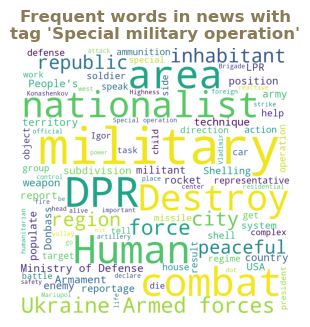

In [70]:
plt.figure(figsize=(3.5,3.5))
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=n_wc,normalize_plurals=False).generate_from_frequencies(frequent_words_eng)
plt.title("Frequent words in news with\ntag 'Special military operation'", 
          weight='bold')
plt.axis("off")
plt.imshow(wc);